# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 2. Поиск по образцу.**

Смена рабочей директории.

## **Часть 1.** Наивный алгоритм поиска по образцу.

Импорт библиотек и модулей.

In [3]:
import numpy as np
import pandas as pd
import time

from modules.utils import *
from modules.plots import *
from modules.bestmatch import *

### **Задача 1.**

В данной задаче вам предстоит самостоятельно реализовать наивный поиск top-$k$ похожих подпоcледовательностей временного ряда на заданный образец поиска.


Сначала выполните считывание временного ряда и образца поиска из файлов *ECG.csv* и *ECG_query.csv* соответственно, которые располагаются в директории *./datasets/part1*. Временной ряд представляет собой показания ЭКГ пациента, образец поиска – фрагмент ЭКГ, обозначающий кардиологическое заболевание. Необходимо по записи ЭКГ пациента определить, имеет ли он данное заболевание сердца.

In [4]:
def load_ts(file_name):

    ts = pd.read_csv(file_name, header=None, delim_whitespace=True)

    return ts

In [5]:
ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = load_ts(ts_url).squeeze().to_numpy()
query = load_ts(query_url).squeeze().to_numpy()

Выполните визулизацию временного ряда и образца поиска с помощью функции `plot_bestmatch_data()` из модуля plots.py.

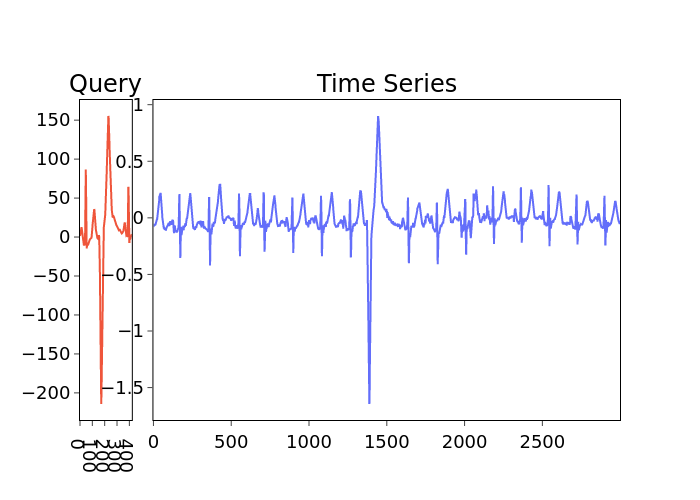

In [6]:
plot_bestmatch_data(ts, query)

Реализуйте самостоятельно наивный поиск top-$k$ подпоследовательностей временного ряда, похожих на образец поиска в смысле DTW меры. Для этого уже подготовлен шаблон класса `NaiveBestMatchFinder` в модуле *bestmatch.py*. Напишите метод `perform()`, выполняющий обнаружение подпоследовательностей ряда, похожих на образец поиска. При этом метод должен избегать попадания в результирующее множество пересекающихся подпоследовательностей. Воспользуйтесь функцией `_top_k_match()` из базового класса `BestMatchFinder`, которая возвращает top-$k$ похожих на образец поиска непересекающихся подпоследовательностей.

При реализации опирайтесь на псевдокод наивного алгоритма поиска, который представлен ниже.

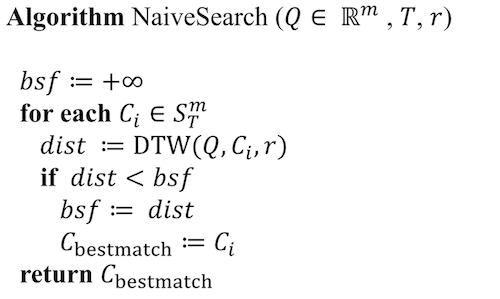

In [7]:
top_k = 2
r = 0.01
exclusion_zone = 1
normalize = True

naive_bestmatch_results = {}

model = NaiveBestMatchFinder(ts, query, exclusion_zone, top_k, normalize, r)
naive_bestmatch_results = model.perform()


Напишите функцию `plot_bestmatch_results()` в модуле *plots.py* для визуализации найденных top-$k$ похожих подпоследовательностей временного ряда на образец поиска. За основу возьмите функцию `plot_bestmatch_data()` и добавьте отображение найденных подпоследовательностей, показанных тем же цветом, что и образец поиска.

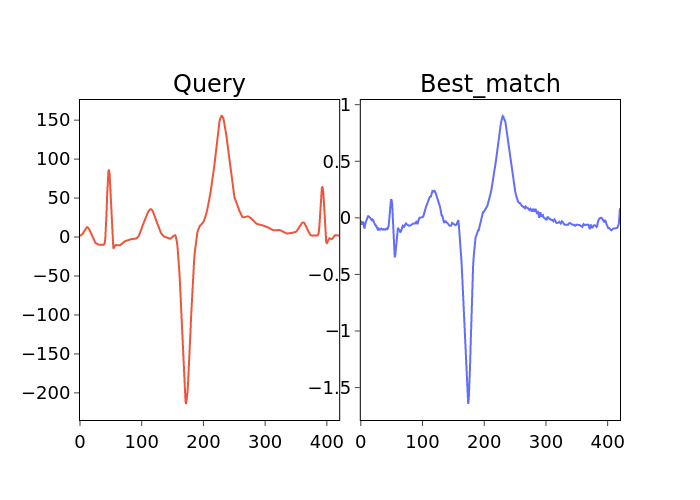

In [8]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

### **Задача 2**.
Проведите эксперименты по исследованию длины образца поиска и ширины полосы Сако—Чиба на время выполнения наивного алгоритма. Длина временного ряда должна быть зафиксирована.

Для проведения экспериментов сгенерируйте временной ряд заданной длины и множество образцов поиска различных длин на основе модели случайных блужданий (функция `random_walk()` в *utils.py*).

In [9]:
n = 2000 # length of time series
m_list = [16, 32, 64, 128] # lengths of query

ts = random_walk(n)

query_list = []
for m in m_list:
    query_list.append(random_walk(m))

In [10]:

top_k = 3
r_list = np.round(np.arange(0, 0.6, 0.1), 2)
exclusion_zone = 1
normalize = True

print(f'query = {r_list}')

naive_times = np.zeros((len(r_list), len(m_list)))

for i in range(len(r_list)):
    for j in range(len(query_list)):
        r = r_list[i]
        query = query_list[j]

        model = NaiveBestMatchFinder(ts, query, exclusion_zone, top_k, normalize, r)

        start = time.time()
        naive_bestmatch_results = model.perform()
        end = time.time()

        naive_times[i, j] = end - start
    print(f'---------r = {r}------------')
    print(f'lead time = {end-start}')
    print('\n')

query = [0.  0.1 0.2 0.3 0.4 0.5]
---------r = 0.0------------
lead time = 1.1336493492126465


---------r = 0.1------------
lead time = 6.976046562194824


---------r = 0.2------------
lead time = 12.542961120605469


---------r = 0.3------------
lead time = 17.545595169067383


---------r = 0.4------------
lead time = 21.740730047225952


---------r = 0.5------------
lead time = 25.416762590408325




Постройте график зависимости времени выполнения наивного алгоритма от длины образца поиска временного ряда и ширины полосы Сако–Чиба.

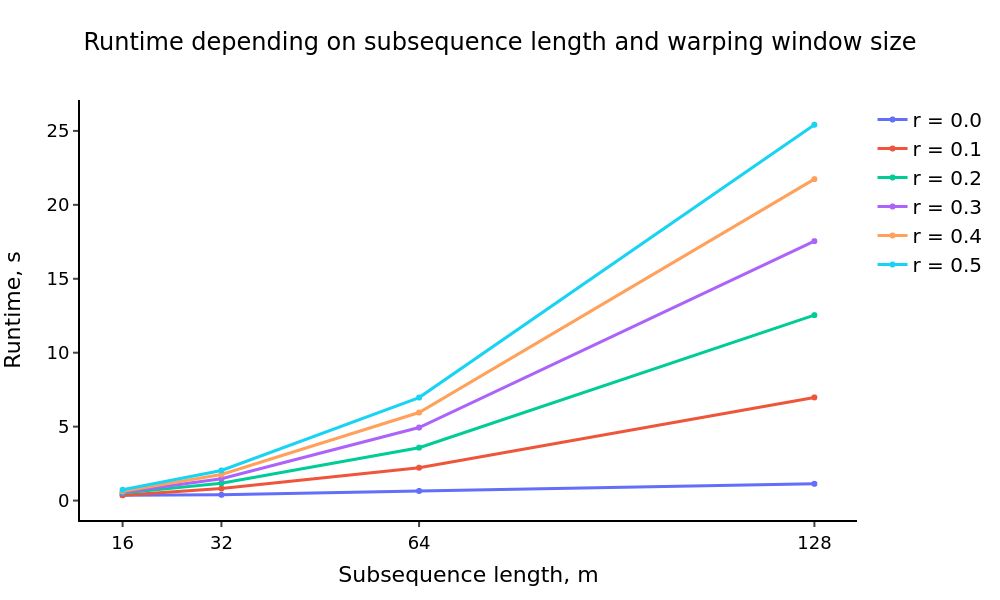

In [11]:
x_title = 'Subsequence length, m'
y_title = 'Runtime, s'
plot_title = 'Runtime depending on subsequence length and warping window size'
trace_titles = np.array([f'r = {r}' for r in r_list])


mplot2d(m_list, naive_times, plot_title, x_title, y_title, trace_titles)

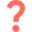
Проанализируйте и изложите содержательный смысл полученных
результатов.

Ответ: время выполнения алгоритма увеличивается пропорционально увеличению query и ширины полосы

## **Часть 2.** Алгоритм UCR-DTW.

Вторая часть практической работы посвящена алгоритму UCR-DTW, который использует нижние границы схожести ($LB_{Kim}\;FL$, $LB_{Keogh}\;\;EC$ и $LB_{Keogh}\;\;EQ$), применяющиеся каскадным образом.

<ul>
<li>
<i>Нижняя граница $LB_{Kim}\;FL$</i> представляет собой евклидово расстояние между первой и последней парами точек временных рядов $Q$ и $C$ длины $n$:

\begin{equation}
    LB_{Kim}\;FL(Q,\;C) = \text{ED}(q_1, c_1) + \text{ED}(q_n, c_n).
\end{equation}
</li>
<li>
<i>Нижняя граница $LB_{Keogh}\;\;EC$</i> показывает минимальную схожесть между оболочкой запроса $E$ (envelope) и кандидатом $C$ и вычисляется следующим образом:

\begin{equation}
    LB_{Keogh}\;\;EC = \sum_{i=1}^n{\left\{
            \begin{array}{cl}
            (c_i - u_i)^2 & \text{if} \; c_i > u_i \\
            (c_i - l_i)^2 & \text{if} \; c_i < l_i\\
            0 & \text{otherwise}.
            \end{array}
            \right.}
\end{equation}

В формуле нахождения $LB_{Keogh}\;\;EC$ последовательности $U = (u_1,..., u_n)$ и $L = (l_1,..., l_n)$ обозначают <i>верхнюю (upper)</i> и
<i>нижнюю (lower)</i> границы оболочки запроса $Q$, которые вычисляются по формуле

\begin{equation}
    u_i = \max(q􏰎_{i-r}\;,..., q_{i+r}\;), \quad l_i = \min(q_{i-r}\;,..., q_{i+r}\;).
\end{equation}

</li>
<li>
<i>Нижняя граница $LB_{Keogh}\;\;EQ$</i> представляет собой евклидово расстояние между запросом Q и оболочкой кандидата $C$, т.е. по сравнению с $LB_{Keogh}\;\;EC$ роли запроса и кандидата меняются местами:

\begin{equation}
    LB_{Keogh}\;\;EQ(Q, C) = LB_{Keogh}\;\;EC(C, Q).
\end{equation}
</li>
</ul>

### **Задача 3.**
Для реализации алгоритма UCR-DTW создан класс `UCR_DTW` в модуле *bestmatch.py*. Реализуйте нижние границы и технику каскадного применения нижних границ при вычислении DTW, заполнив пропуски в классе `UCR_DTW`. Псевдокод алгоритма UCR_DTW представлен ниже.

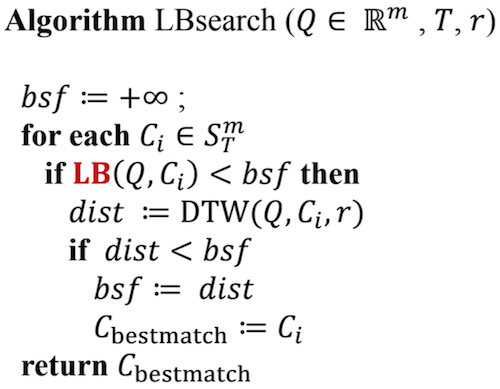

In [12]:
top_k = 2
r = 0.01
exclusion_zone = 1
normalize = True

ucr_dtw_results = {}

model = UCR_DTW(ts, query, exclusion_zone, top_k, normalize, r)
ucr_dtw_results = model.perform()

ucr_dtw_results

{'index': [3977],
 'distance': [28.047670833616476],
 'lb_Kim_num': 0,
 'lb_KeoghCQ_num': 1778,
 'lb_KeoghQC_num': 1708}

Визуализируйте количество неотброшенных и отброшенных каждой нижней границей подпоследовательностей временного ряда в виде круговой диаграммы.

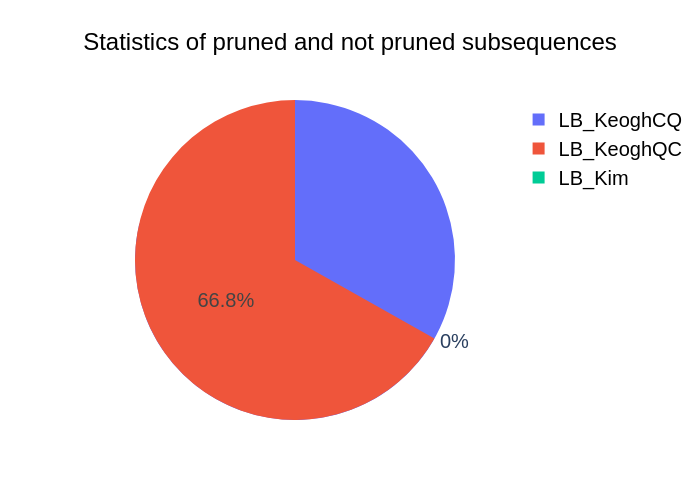

In [16]:
not_pruned_num = (len(ts) - len(query) + 1) - (ucr_dtw_results['lb_Kim_num'] + ucr_dtw_results['lb_KeoghCQ_num'] + ucr_dtw_results['lb_KeoghQC_num'])

statistics = [not_pruned_num, ucr_dtw_results['lb_Kim_num'], ucr_dtw_results['lb_KeoghCQ_num'], ucr_dtw_results['lb_KeoghQC_num']]
labels = ['Not pruned', 'LB_Kim', 'LB_KeoghCQ', 'LB_KeoghQC']

plot_title = 'Statistics of pruned and not pruned subsequences'

pie_chart(labels, statistics, plot_title)

### **Задача 4.**

Проведите эксперименты по исследованию длины образца поиска и ширины полосы Сако—Чиба на быстродействие алгоритма UCR-DTW. Сравните время выполнения алгоритма UCR-DTW с наивным алгоритмом.

Для проведения экспериментов используйте временной ряд и множество образцов поиска из задачи 2.

In [18]:
ucr_dtw_times = np.zeros((len(r_list), len(m_list)))

for i in range(len(r_list)):
    for j in range(len(query_list)):
        r = r_list[i]
        query = query_list[j]

        model = UCR_DTW(ts, query, exclusion_zone, top_k, normalize, r)

        start = time.time()
        ucr_dtw_results = model.perform()
        end = time.time()

        ucr_dtw_times[i, j] = end - start
    print(f'---------r = {r}------------')
    print(f'lead time = {end-start}')
    print('\n')

---------r = 0.0------------
lead time = 3.114694118499756


---------r = 0.05------------
lead time = 7.102508306503296


---------r = 0.1------------
lead time = 11.061672449111938


---------r = 0.15000000000000002------------
lead time = 14.670209169387817


---------r = 0.2------------
lead time = 18.281832456588745


---------r = 0.25------------
lead time = 21.278138637542725


---------r = 0.30000000000000004------------
lead time = 24.53809905052185


---------r = 0.35000000000000003------------
lead time = 26.81212544441223


---------r = 0.4------------
lead time = 29.01786518096924


---------r = 0.45------------
lead time = 31.19046688079834


---------r = 0.5------------
lead time = 34.27678608894348


---------r = 0.55------------
lead time = 36.417399883270264


---------r = 0.6000000000000001------------
lead time = 37.27300715446472


---------r = 0.65------------
lead time = 38.128732681274414


---------r = 0.7000000000000001------------
lead time = 39.3428251743316

Постройте график зависимости времени выполнения алгоритма UCR-DTW от длины образца поиска и ширины полосы Сако–Чиба.

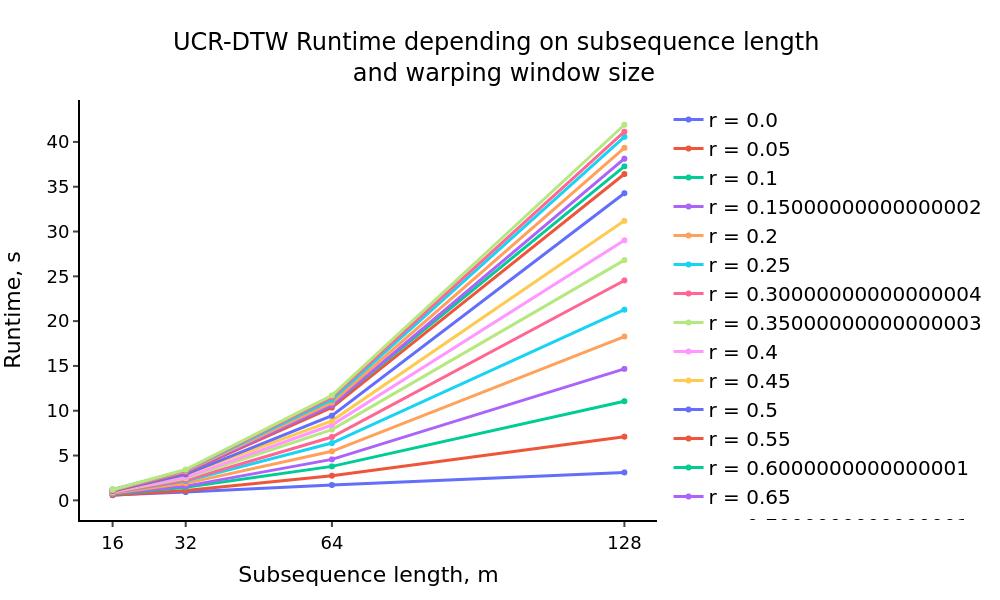

In [19]:
x_title = 'Subsequence length, m'
y_title = 'Runtime, s'
plot_title = 'UCR-DTW Runtime depending on subsequence length <br> and warping window size'
trace_titles = np.array([f'r = {r}' for r in r_list])


mplot2d(m_list, ucr_dtw_times, plot_title, x_title, y_title, trace_titles)

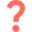
Проанализируйте и изложите содержательный смысл полученных результатов. Сравните время выполнения наивного поиска и алгорима UCR-DTW для различных длин образца и ширины полосы Сако–Чиба.

За счет использования нижних границ подобия UCR-DTW более быстрый чем NaiveSearch

Время выполнения алгоритма линейно зависит от длины последовательности и ширины полосы Сако-Чиба